<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/Lecture-AI_programming/week05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week05


In [39]:
import torch
import numpy as np

In [40]:
for c in [torch, np]:
  print(c.__version__)

2.2.1+cu121
1.25.2


In [41]:
!pip install --quiet torchvision
!pip install --quiet torchsummary

In [42]:
from torch.nn import Module, init, Linear, Parameter, MSELoss, ReLU
from torch import optim
import matplotlib.pyplot as plt
import torchvision
import torchsummary

# Data 생성부
- input
- output: x (tensor), y (tensor) = y_ideal + noise

In [43]:
def gen_xy():
  x = np.linspace(-10, 10, 100)
  y_ideal = 1.8 * x + 32.
  y = y_ideal + 8. * np.random.randn((100))

  return x, y, y_ideal

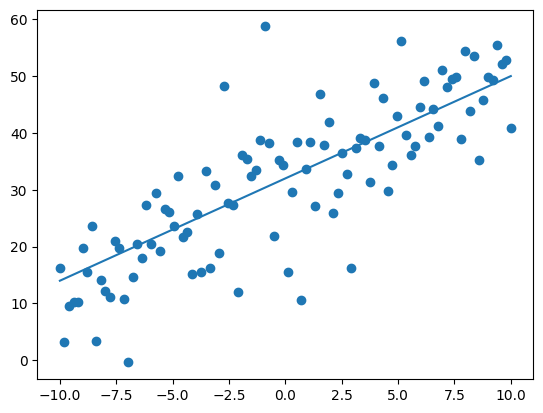

In [44]:
x, y, y_ideal = gen_xy()

plt.plot(x, y_ideal)
plt.scatter(x, y)

### tensor로 변환 (+shape)

In [45]:
x = torch.tensor(x).float()
y = torch.tensor(y).float()
x = x.reshape(-1,1)
y = y.reshape(-1,1)

print(x.shape, type(x))
print(y.shape, type(y))

torch.Size([100, 1]) <class 'torch.Tensor'>
torch.Size([100, 1]) <class 'torch.Tensor'>


# Model
## (1) 선형모델

In [46]:
class DsLinearModel(Module):
  def __init__(self,
               n_in_f, # input vector의 차원 수
               n_out_f # output vector의 차원 수
               ):
    super().__init__()

    init_w = torch.ones(1,1)
    init_b = torch.zeros(1)
    self.l0 = Linear(n_in_f, n_out_f)
    self.l0.weight = Parameter(init_w)
    self.l0.bias = Parameter(init_b)

  def forward(self, x):
    y = self.l0(x)
    return y

In [47]:
linearModel = DsLinearModel(1,1)

for idx, c in enumerate(linearModel.named_parameters()):
  print(idx, c)
print()

for idx, c in enumerate(linearModel.parameters()):
  print(idx, c)

0 ('l0.weight', Parameter containing:
tensor([[1.]], requires_grad=True))
1 ('l0.bias', Parameter containing:
tensor([0.], requires_grad=True))

0 Parameter containing:
tensor([[1.]], requires_grad=True)
1 Parameter containing:
tensor([0.], requires_grad=True)


In [48]:
for idx, cl in enumerate(linearModel.named_children()): # cl: child layer
  print(idx, cl)
print()

for idx, cl in enumerate(linearModel.children()): # cl: child layer
  print(idx, cl)

0 ('l0', Linear(in_features=1, out_features=1, bias=True))

0 Linear(in_features=1, out_features=1, bias=True)


In [49]:
for idx, modu in enumerate(linearModel.named_modules()):
  print(idx, modu)
print()

for idx, modu in enumerate(linearModel.modules()):
  print(idx, modu)

0 ('', DsLinearModel(
  (l0): Linear(in_features=1, out_features=1, bias=True)
))
1 ('l0', Linear(in_features=1, out_features=1, bias=True))

0 DsLinearModel(
  (l0): Linear(in_features=1, out_features=1, bias=True)
)
1 Linear(in_features=1, out_features=1, bias=True)


In [50]:
lin_pred = linearModel(x)
lin_pred

tensor([[-10.0000],
        [ -9.7980],
        [ -9.5960],
        [ -9.3939],
        [ -9.1919],
        [ -8.9899],
        [ -8.7879],
        [ -8.5859],
        [ -8.3838],
        [ -8.1818],
        [ -7.9798],
        [ -7.7778],
        [ -7.5758],
        [ -7.3737],
        [ -7.1717],
        [ -6.9697],
        [ -6.7677],
        [ -6.5657],
        [ -6.3636],
        [ -6.1616],
        [ -5.9596],
        [ -5.7576],
        [ -5.5556],
        [ -5.3535],
        [ -5.1515],
        [ -4.9495],
        [ -4.7475],
        [ -4.5455],
        [ -4.3434],
        [ -4.1414],
        [ -3.9394],
        [ -3.7374],
        [ -3.5354],
        [ -3.3333],
        [ -3.1313],
        [ -2.9293],
        [ -2.7273],
        [ -2.5253],
        [ -2.3232],
        [ -2.1212],
        [ -1.9192],
        [ -1.7172],
        [ -1.5152],
        [ -1.3131],
        [ -1.1111],
        [ -0.9091],
        [ -0.7071],
        [ -0.5051],
        [ -0.3030],
        [ -0.1010],


## (2) ANN 모델

In [51]:
class DsANN(Module):
  def __init__(self,
               n_in_f, # input vector의 차원 수
               n_out_f # output vector의 차원 수
               ):
    super().__init__()

    self.l0 = Linear(n_in_f, 32)
    self.relu0 = ReLU()
    self.l1 = Linear(32, 32)
    self.relu1 = ReLU()
    self.l2 = Linear(32, n_out_f)

    with torch.no_grad():
      init.constant_(self.l0.bias, 0.)
      init.xavier_uniform(self.l0.weight)

  def forward(self, x):
    x = self.l0(x)
    x = self.relu0(x)
    x = self.l1(x)
    x = self.relu1(x)
    y = self.l2(x)
    return y

## torch.nn.init 모듈
ANN을 구현할 때, 각 layer의 weight 와 bias를 초기화하는 방법을 제공함.

- 초기화는 ANN의 수렴 속도 및 학습 안정화에 매우 큰 영향을 줌.
- torch.nn.init는 일반적으로 사용되는 다양한 초기화 방법들이 구현되어 있음.

### `.uniform_(tensor, a=0., b=1.)`
- 지정된 parameters를 uniform distance로 초기화
- a와 b는 값의 범위를 지정하는데 사용됨: [a,b)

### `.normal_(tensor, mean=0., std=1.)`
- normal distribution으로 초기화.

### `.constant_(tensor, val=0.)`
- val 에 지정된 상수값으로 초기화.

### `.ones_() and .zeros_()`
- 0과 1로 초기화.

In [52]:
ANNmodel = DsANN(1,1)

for idx, c in enumerate(ANNmodel.named_parameters()):
  print(idx, c)
print()

for idx, c in enumerate(ANNmodel.parameters()):
  print(idx, c)

0 ('l0.weight', Parameter containing:
tensor([[-0.2077],
        [-0.3890],
        [ 0.3151],
        [-0.0054],
        [ 0.2290],
        [-0.1519],
        [ 0.0928],
        [ 0.2827],
        [-0.0380],
        [ 0.3525],
        [ 0.0103],
        [ 0.0015],
        [-0.3570],
        [ 0.2997],
        [ 0.0300],
        [-0.3543],
        [-0.0371],
        [-0.0863],
        [-0.0005],
        [-0.1006],
        [ 0.0243],
        [ 0.2538],
        [ 0.2041],
        [-0.3375],
        [ 0.1948],
        [ 0.3861],
        [ 0.2995],
        [-0.3375],
        [ 0.1029],
        [-0.0826],
        [ 0.2640],
        [ 0.3431]], requires_grad=True))
1 ('l0.bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))
2 ('l1.weight', Parameter containing:
tensor([[ 0.0088, -0.0951,  0.0766,  ...,  0.0541, -0.0998,  0.0679],
        [ 0.0076, -0.1

<ipython-input-51-c99a1fa6031d>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.l0.weight)


In [53]:
for idx, cl in enumerate(ANNmodel.named_children()): # cl: child layer
  print(idx, cl)
print()

for idx, cl in enumerate(ANNmodel.children()): # cl: child layer
  print(idx, cl)

0 ('l0', Linear(in_features=1, out_features=32, bias=True))
1 ('relu0', ReLU())
2 ('l1', Linear(in_features=32, out_features=32, bias=True))
3 ('relu1', ReLU())
4 ('l2', Linear(in_features=32, out_features=1, bias=True))

0 Linear(in_features=1, out_features=32, bias=True)
1 ReLU()
2 Linear(in_features=32, out_features=32, bias=True)
3 ReLU()
4 Linear(in_features=32, out_features=1, bias=True)


In [54]:
for idx, modu in enumerate(ANNmodel.named_modules()):
  print(idx, modu)
print()

for idx, modu in enumerate(ANNmodel.modules()):
  print(idx, modu)

0 ('', DsANN(
  (l0): Linear(in_features=1, out_features=32, bias=True)
  (relu0): ReLU()
  (l1): Linear(in_features=32, out_features=32, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=32, out_features=1, bias=True)
))
1 ('l0', Linear(in_features=1, out_features=32, bias=True))
2 ('relu0', ReLU())
3 ('l1', Linear(in_features=32, out_features=32, bias=True))
4 ('relu1', ReLU())
5 ('l2', Linear(in_features=32, out_features=1, bias=True))

0 DsANN(
  (l0): Linear(in_features=1, out_features=32, bias=True)
  (relu0): ReLU()
  (l1): Linear(in_features=32, out_features=32, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=32, out_features=1, bias=True)
)
1 Linear(in_features=1, out_features=32, bias=True)
2 ReLU()
3 Linear(in_features=32, out_features=32, bias=True)
4 ReLU()
5 Linear(in_features=32, out_features=1, bias=True)


In [55]:
ann_pred = ANNmodel(x)
ann_pred

tensor([[-0.0786],
        [-0.0784],
        [-0.0782],
        [-0.0781],
        [-0.0780],
        [-0.0779],
        [-0.0778],
        [-0.0777],
        [-0.0776],
        [-0.0775],
        [-0.0774],
        [-0.0773],
        [-0.0772],
        [-0.0771],
        [-0.0770],
        [-0.0768],
        [-0.0767],
        [-0.0766],
        [-0.0765],
        [-0.0764],
        [-0.0763],
        [-0.0762],
        [-0.0761],
        [-0.0760],
        [-0.0759],
        [-0.0759],
        [-0.0760],
        [-0.0762],
        [-0.0764],
        [-0.0766],
        [-0.0767],
        [-0.0769],
        [-0.0771],
        [-0.0773],
        [-0.0774],
        [-0.0776],
        [-0.0784],
        [-0.0793],
        [-0.0802],
        [-0.0810],
        [-0.0793],
        [-0.0777],
        [-0.0760],
        [-0.0733],
        [-0.0691],
        [-0.0624],
        [-0.0564],
        [-0.0552],
        [-0.0544],
        [-0.0531],
        [-0.0547],
        [-0.0558],
        [-0.

# Loss
## (1) 선형 모델

In [56]:
loss_func = MSELoss()

l = loss_func(lin_pred, y)
l

tensor(1082.3280, grad_fn=<MseLossBackward0>)

## (2) ANN 모델

In [57]:
loss_func = MSELoss()

l = loss_func(ann_pred, y)
l

tensor(1188.9702, grad_fn=<MseLossBackward0>)

# Training Loop

In [58]:
def training_loop(
    x, y,
    model,
    lr,
    n_epochs,
):

  model.train()
  # model.eval()

  optimizer = optim.SGD(
    model.parameters(),
    lr = lr,
  )

  print(n_epochs)


  for epoch in range(n_epochs):
    pred = model(x)
    l = loss_func(pred, y)

    if torch.isinf(l).any(): # 무한대로 발산하면
      print('Error: diverge!')
      break

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')

  return model

# Train
## (1) 선형 모델

In [59]:
linearModel = DsLinearModel(1,1)
linearModel = training_loop(
    x, y,
    linearModel,
    1e-3,
    7000,
)

7000
Epoch 0: Loss 1082.3280
Epoch 1000: Loss 82.2682
Epoch 2000: Loss 64.5594
Epoch 3000: Loss 64.2364
Epoch 4000: Loss 64.2305
Epoch 5000: Loss 64.2304
Epoch 6000: Loss 64.2304


In [60]:
ANNmodel = DsANN(1,1)
ANNmodel = training_loop(
    x, y,
    ANNmodel,
    1e-3,
    7000,
)

<ipython-input-51-c99a1fa6031d>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.l0.weight)


7000
Epoch 0: Loss 1183.1591
Epoch 1000: Loss 65.1092
Epoch 2000: Loss 63.9213
Epoch 3000: Loss 63.1424
Epoch 4000: Loss 62.5013
Epoch 5000: Loss 61.2798
Epoch 6000: Loss 60.9193


# Evaluation
## (1) 선형회귀

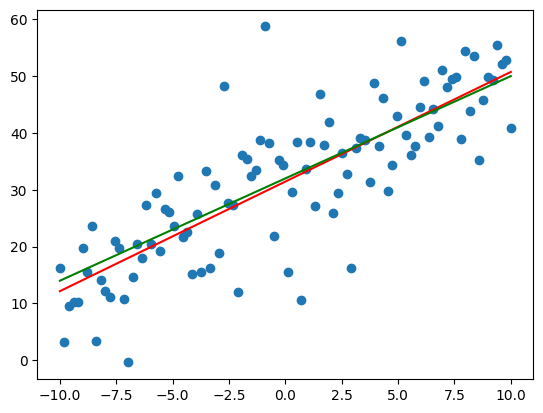

In [61]:
pred = linearModel(x)
plt.scatter(x.detach().numpy(),y.detach().numpy())
plt.plot(x.detach().numpy(), pred.detach().numpy(), color='r')
plt.plot(x.detach().numpy(), y_ideal, color='g')

In [62]:
from torchsummary import summary

summary(linearModel, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## (2) ANN

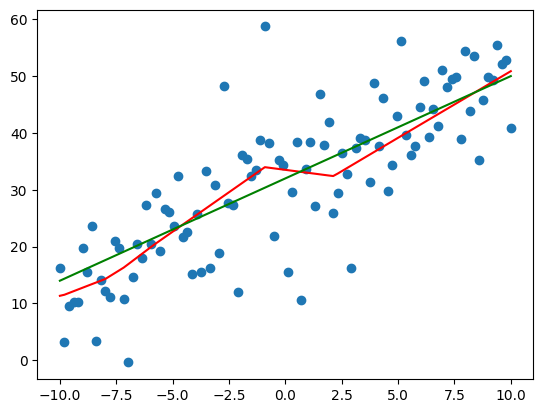

In [63]:
pred = ANNmodel(x)
plt.scatter(x.detach().numpy(),y.detach().numpy())
plt.plot(x.detach().numpy(), pred.detach().numpy(), color='r')
plt.plot(x.detach().numpy(), y_ideal, color='g')

In [64]:
from torchsummary import summary

summary(ANNmodel, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              64
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
